# Import package and initialize model

In [1]:
from branch_calm_net.models import *

DEVICE = torch.device('cpu')

# GROUPING DECLARATION
subject_group = { # map: ID_# -> group_id
    "ID_0": '0',
    "ID_1": '1',
    "ID_2": '2'
}

# MODEL CONFIGURATION and TRAINING PARAMETERS
config = {
    'model_params': {
        'device': DEVICE,
        'in_size': 8,
        'AE': 'lstm', 
        'AE_num_layers': 1,
        'AE_hidden_size': 128,
        'covariate_size': 4, # number of covariates
        'shared_in_size': 128, # init bottleneck size
        'shared_hidden_size': 256,
        'num_branches': 7, # when equal to 1, it is equivalent to CALM_Net
        'groups': subject_group,
        'heads_hidden_size': 64,
        'num_classes': 2
    },
    'training_params': {
        'device': torch.device('cpu'), 
        'loss_weight': {
            'alpha': 1e-4,
            'beta': 1,
            'theta': 1 / 22, # 1 over number of students
        },
        # 'class_weights': [0.6456, 0.5635, 1.0000],
        'class_weights': [0.6456, 0.5635+1.0000],
        'global_lr': 1e-5,
        'branching_lr': 1e-5,
        'weight_decay': 1e-4,
        'epochs': 50, 
        'batch_size': 4,
        'use_histogram': True,
        'use_covariates': True, 
        'use_decoder': True,
    }
}

# CONSTUCT MODEL
model = MultitaskAutoencoder(config['model_params'], use_covariates=True).to(DEVICE)
model.eval()

MultitaskAutoencoder(
  (autoencoder): autoencoder(
    (encoder): LSTM(8, 128, batch_first=True)
    (encoder_act): ReLU()
    (decoder): LSTM(128, 8, batch_first=True)
    (decoder_act): Sigmoid()
  )
  (branching): branching(
    (probabilities): ParameterDict(
        (0): Parameter containing: [torch.FloatTensor of size 7]
        (1): Parameter containing: [torch.FloatTensor of size 7]
        (2): Parameter containing: [torch.FloatTensor of size 7]
    )
  )
  (branch_layer): branch_layer(
    (branches): ModuleDict(
      (0): Sequential(
        (0): Linear(in_features=132, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=132, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
        (3): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=132, out_

# Example Input and Prediction Output

In [2]:
# GENERATE RANDOM EXAMPLE DATA
sample_x = torch.rand(3, 24, 8).to(DEVICE) # N, L, D
sample_ids = ['1', '0', '2']
sample_cov = torch.rand(3, 4).to(DEVICE) # N, E_c

# FORWARD PASS
final_out, AE_out = model(sample_x, sample_ids, covariate_data=sample_cov)

# print
print("Input Size:", sample_x.shape)
print("Covariates Size:", sample_cov.shape)
print("Prediction Output Size:", final_out.shape)
print("Decoder Output Size:", AE_out.shape)

Input Size: torch.Size([3, 24, 8])
Covariates Size: torch.Size([3, 4])
Prediction Output Size: torch.Size([3, 2])
Decoder Output Size: torch.Size([3, 24, 8])


# Train the model

100%|██████████| 50/50 [00:03<00:00, 16.25it/s]


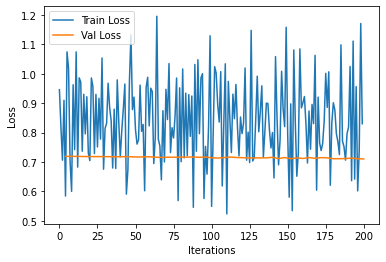

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# GENERATE RANDOM EXAMPLE DATA
sample_x = torch.rand(16, 24, 8).to(DEVICE) # N, L, D
sample_y = torch.rand(16, 2).to(DEVICE) # N, C
sample_ids = np.random.choice(['1', '0', '2'], 16, replace=True)
sample_cov = torch.rand(16, 4).to(DEVICE) # N, E_c

val_x = torch.rand(2, 24, 8).to(DEVICE) # N, L, D
val_y = torch.rand(2, 2).to(DEVICE) # N, C
val_ids = np.random.choice(['1', '0', '2'], 2, replace=True)
val_cov = torch.rand(2, 4).to(DEVICE) # N, E_c

# fit function
train_loss, train_it, val_loss, val_it = model.fit(
    config,
    sample_x,
    sample_y,
    sample_ids,
    sample_cov=sample_cov,
    val_x=val_x,
    val_y=val_y,
    val_ids=val_ids,
    val_cov=val_cov
)

# check function
plt.plot(train_it, train_loss, label="Train Loss")
plt.plot(val_it, val_loss, label="Val Loss")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Inspect the Branching/Grouping

In [11]:
# get branching records
branches = model.record_branch(return_only=True)

# fetch probability distribution
groups = dict() # map: group_id -> list(subject ids)
for id_ in branches:
    last_prob = branches[id_][-1]
    chosen_group = np.argmax(last_prob)
    if groups.get(chosen_group) is None:
        groups[chosen_group] = list()
    groups[chosen_group].append(id_)

# sort by group id
sorted_groups_items = sorted(groups.items(), key=lambda x: int(x[0]))
groups = dict()
for k, v in sorted_groups_items:
    groups[k] = v

# logs
for group_id in groups:
    print("Group {}: {}\n".format(group_id, groups[group_id]))

Group 0: ['0']

Group 1: ['2']

Group 3: ['1']



Max: 0.1428815555249055 Min: 0.14284873845033383


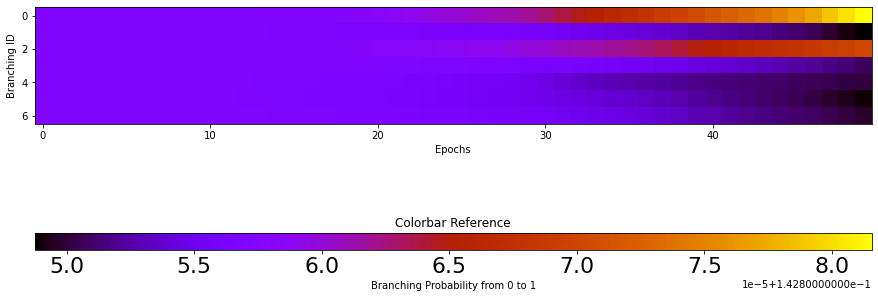

In [4]:
def gumbel_softmax(mat, tau=0.1, decay=True):
    if not decay:
        return np.array(mat), [0 for _ in range(len(mat))]
    ts = list()
    res = list()
    for i in range(len(mat)):
        ts.append(tau)
        v = np.exp(np.log(mat[i]) / tau)
        res.append(v / np.sum(v))
        tau = max(0.01, tau*0.98)
    res = np.array(res)
    print("Max:", np.max(res), "Min:", np.min(res))
    return res, ts

# process
def check_branch_evolve(model, sub_ind="0", tau=0.1, decay=True, cmap='jet', step_size=3):
    # get branching evolve parameters
    branches = model.record_branch(return_only=True)[sub_ind]

    # transform
    mat, ts = gumbel_softmax(branches, tau=tau, decay=decay)
    inds = [i for i in range(len(mat)) if i % step_size == 0]
    mat = mat[inds]

    # heat map
    plt.figure(figsize = (15,5))
    plt.imshow(mat.T, cmap=cmap)
    tick_list = np.linspace(0, 1.0, 5)
    cb = plt.colorbar(orientation='horizontal', aspect=50, location="bottom", pad=0.4)
    cb.ax.tick_params(labelsize=22) 
    cb.ax.set_title('Colorbar Reference')
    cb.ax.set_xlabel('Branching Probability from 0 to 1')
#     cb.ax.legend()
#     cb.ax.set_yticklabels(tick_list)
    plt.xlabel("Epochs")
    plt.ylabel("Branching ID")
    plt.show()

check_branch_evolve(model, sub_ind="0", tau=1e1, step_size=1, cmap='gnuplot')